In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from PIL import Image
import os

In [2]:
## File Imports
dataset_path = './Data/'

train_labels = pd.read_csv(os.path.join(dataset_path, 'train_labels.csv'))

train_path = dataset_path + 'train/'
test_path = dataset_path + 'test/'

test_data = pd.DataFrame(os.listdir(test_path), columns=['id'])
test_data['id'] = [os.path.splitext(filename)[0] for filename in test_data['id']]
test_data['label'] = [0] * len(test_data)
print(test_data)

                                             id  label
0      00006537328c33e284c973d7b39d340809f7271b      0
1      0000ec92553fda4ce39889f9226ace43cae3364e      0
2      00024a6dee61f12f7856b0fc6be20bc7a48ba3d2      0
3      000253dfaa0be9d0d100283b22284ab2f6b643f6      0
4      000270442cc15af719583a8172c87cd2bd9c7746      0
...                                         ...    ...
57453  fffdd1cbb1ac0800f65309f344dd15e9331e1c53      0
57454  fffdf4b82ba01f9cae88b9fa45be103344d9f6e3      0
57455  fffec7da56b54258038b0d382b3d55010eceb9d7      0
57456  ffff276d06a9e3fffc456f2a5a7a3fd1a2d322c6      0
57457  ffffeb4c0756098c7f589b7beec08ef1899093b5      0

[57458 rows x 2 columns]


In [3]:
## Data Analysis
print("Training Set")
print(train_labels['label'].value_counts())
print("Null: ",train_labels.isnull().sum())

missing_images = []
for image_name in train_labels['id']:
    image_path = train_path + f'{image_name}.tif'
    if not os.path.exists(image_path):
        missing_images.append(image_name)

print(f"Missing images: {len(missing_images)}")

print("Test Set")
print(f"Images: {len(test_data)}")

Training Set
label
0    130908
1     89117
Name: count, dtype: int64
Null:  id       0
label    0
dtype: int64
Missing images: 0
Test Set
Images: 57458


In [4]:
from torchvision import transforms

# Define preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),  # Convert the image to a tensor and normalize to [0, 1]
    transforms.Normalize(mean=[0.5], std=[0.5]),  # Optionally normalize to [-1, 1]
])

In [5]:
from sklearn.model_selection import train_test_split

# Split the data
train_set, val_set = train_test_split(train_labels, test_size=0.2, stratify=train_labels['label'], random_state=42)

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")

Training set size: 176020
Validation set size: 44005


In [6]:
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image

class CancerDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        label = self.dataframe.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, f"{img_name}.tif")
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, label

# Create datasets
train_dataset = CancerDataset(train_set, os.path.join(dataset_path, 'train'), transform=preprocess)
val_dataset = CancerDataset(val_set, os.path.join(dataset_path, 'train'), transform=preprocess)
test_dataset = CancerDataset(test_data, os.path.join(dataset_path, 'test'), transform=preprocess)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes (binary classification)
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

C:\Users\Edward\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Edward\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
criterion = nn.BCEWithLogitsLoss()  # Combines sigmoid activation with binary cross-entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
train_losses = []
val_losses = []
val_accuracies = []
num_epochs = 25
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device, dtype=torch.float)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.squeeze(), labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        all_preds = []
        all_labels = []
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_accuracy = sum(1 for x, y in zip(all_preds, all_labels) if x == y) / len(all_labels)
    val_accuracies.append(val_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')
    scheduler.step(val_loss)

Epoch [1/25], Train Loss: 0.3816, Val Loss: 0.3795, Val Accuracy: 0.8347
Validation Loss: 0.3795
Epoch [2/25], Train Loss: 0.3256, Val Loss: 0.2826, Val Accuracy: 0.8823
Validation Loss: 0.2826
Epoch [3/25], Train Loss: 0.2915, Val Loss: 0.2986, Val Accuracy: 0.8749
Validation Loss: 0.2986
Epoch [4/25], Train Loss: 0.2662, Val Loss: 0.2519, Val Accuracy: 0.8961
Validation Loss: 0.2519
Epoch [5/25], Train Loss: 0.2471, Val Loss: 0.2462, Val Accuracy: 0.8972
Validation Loss: 0.2462
Epoch [6/25], Train Loss: 0.2349, Val Loss: 0.2377, Val Accuracy: 0.8999
Validation Loss: 0.2377
Epoch [7/25], Train Loss: 0.2196, Val Loss: 0.2161, Val Accuracy: 0.9125
Validation Loss: 0.2161
Epoch [8/25], Train Loss: 0.2077, Val Loss: 0.2650, Val Accuracy: 0.8961
Validation Loss: 0.2650
Epoch [9/25], Train Loss: 0.1981, Val Loss: 0.2046, Val Accuracy: 0.9181
Validation Loss: 0.2046
Epoch [10/25], Train Loss: 0.1913, Val Loss: 0.2045, Val Accuracy: 0.9186
Validation Loss: 0.2045
Epoch [11/25], Train Loss: 0.

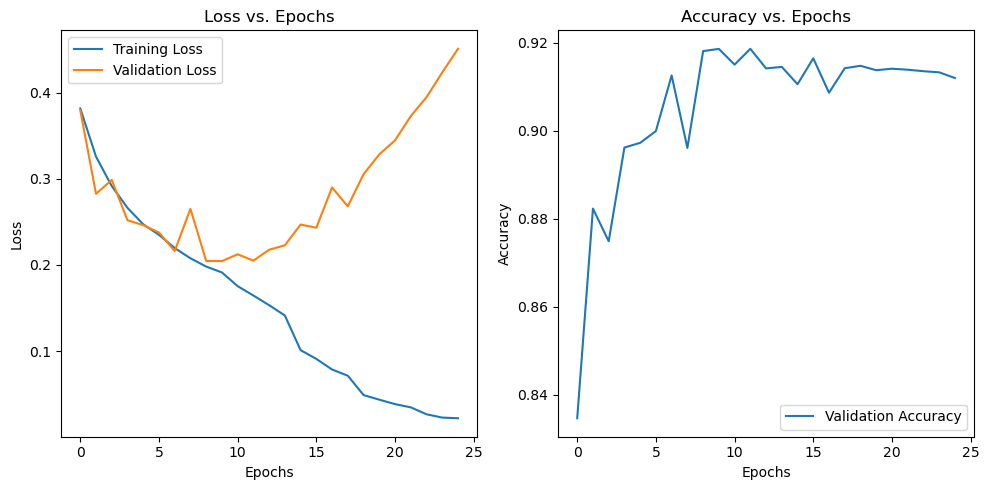

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the validation accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from torchvision import transforms

model.eval()
all_preds = []
name = []
val_loss = 0.0

with torch.no_grad():
        all_preds = []
        all_labels = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device, dtype=torch.float)
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            preds = torch.sigmoid(outputs).squeeze() > 0.5
            all_preds.extend(preds.cpu().numpy())

# Convert predictions to binary labels (0 or 1)
all_preds = [1 if p > 0.5 else 0 for p in all_preds]
test_data['label'] = all_preds

test_data.to_csv('submision.csv', index = False)

print(submission.head())


Empty DataFrame
Columns: [id, label]
Index: []


In [22]:
# Save the model
torch.save(model.state_dict(), 'cancer_detection_model.pth')

# Load the model (for later use)
model.load_state_dict(torch.load('cancer_detection_model.pth'))
model.eval()

C:\Users\Edward\AppData\Local\Temp\ipykernel_18852\3400278482.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cancer_detection_model.pt

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

ValueError: Found input variables with inconsistent numbers of samples: [0, 57458]

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

In [ ]:
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(all_labels, all_preds)
print(f'AUC-ROC: {auc_roc:.4f}')

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
print(f'Confusion Matrix:\n{cm}')

In [ ]:
def plot_history(history, metric):
    """
    Plot model training history.
    Args:
    - history: Training history returned by model.fit()
    - metric: Metric to be plotted (e.g., 'accuracy', 'loss')
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.title('Model ' + metric.title())
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

# Displaying results
plt.figure(figsize=(12, 5))
plot_history(scheduler, 'accuracy')
plot_history(scheduler, 'loss')